# Проект для «Викишоп»

## Цель исследования:
Обучить модель классифицировать комментарии на позитивные и негативные, чтобы отправлять токсичные комментарии на модерацию. 

## Ход исследования:
- Подготовка данных. Загрузим данные для ознакомления. На данном этапе будет выполнен анализ данных.
- Обучение моделей. На данном этапе обучим разные модели с различными гиперпараметрами:
 - LogisticRegression,
 - DecisionTreeClassifier,
 - CatBoostClassifier,
 - SGDClassifier.
- Анализ модели. Проанализируем данные и делаем вывод о том, какая модель подходит лучше для выполнения задачи.


Описание данных:

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах: клиенты предлагают свои правки и комментируют изменения других. 

Признаки:

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Примечание:

Необходимо предложить модель со значением метрики качества F1 не меньше 0.75.

## Подготовка данных
Создадим рабочую среду.

In [1]:
!pip install yellowbrick

In [2]:
!pip install pymystem3

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import string
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanasklyanchuk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Ознакомление с данными

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Избавимся от столбца "Unnamed: 0" - он не содержит информации важной для анализа.

In [6]:
df =df.drop('Unnamed: 0', axis=1)

In [7]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Видим, что англоязычный текст содержит как верхний, так и нижний регистр, знаки пунктуации и прочее. Учтем эти данные при подготовке текста к обучению.

Рассмотрим как распределен целевой признак.

In [8]:
print(df['toxic'].value_counts())
disbalance = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print(f'Количество позитивных комментариев превышает количество негативных в {round(disbalance, 1)} раз.')

0    143106
1     16186
Name: toxic, dtype: int64
Количество позитивных комментариев превышает количество негативных в 8.8 раз.


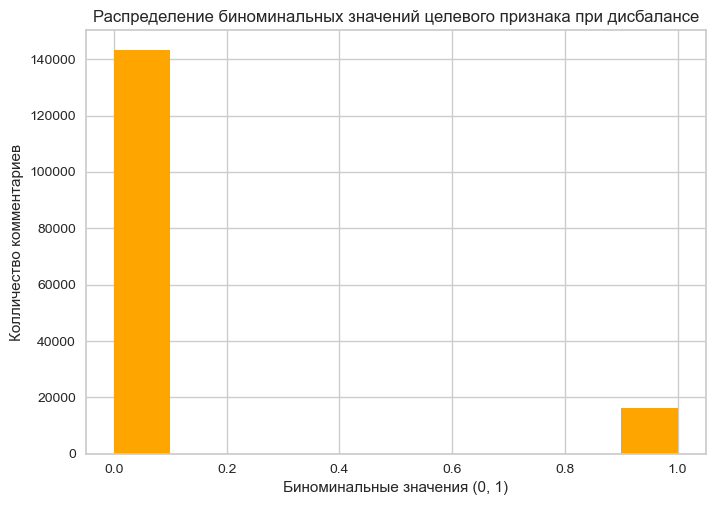

In [9]:
df['toxic'].hist(color='orange')
plt.title('Распределение биноминальных значений целевого признака при дисбалансе')
plt.xlabel("Биноминальные значения (0, 1)")
plt.ylabel("Колличество комментариев")
plt.show()

Мы наблюдаем серьезный дисбаланс между биноминальными значениями целевого признака. Нужно будет проанализировать, как балансировка поможет улучшить точность предсказаний.

Посмотрим на длинну текста в комментариях.

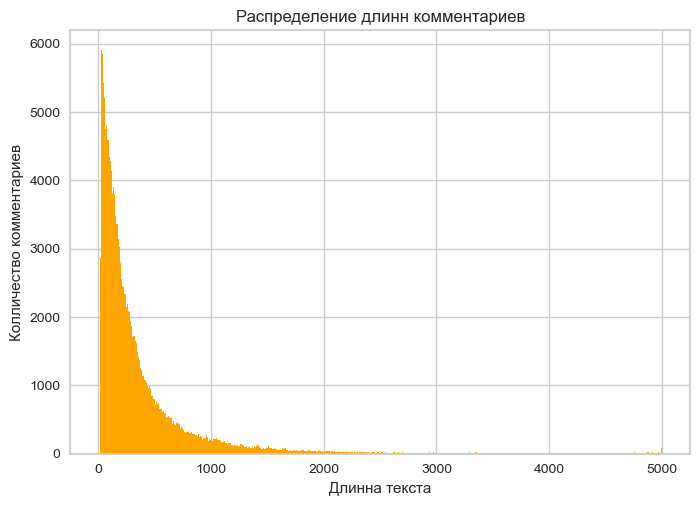

In [10]:
comment_lengths = [len(sentence) for sentence in df['text']]
plt.hist(comment_lengths,500,color='orange')
plt.title("Распределение длинн комментариев")
plt.xlabel("Длинна текста")
plt.ylabel("Колличество комментариев")
plt.show()

Видим, что тексты различной длины: чаще короткие, реже обстоятельные многословные тексты. Для работы будем использовать все данные.

In [11]:
print(f'Колличество дубликатов: {df.duplicated().sum()}')

Колличество дубликатов: 0


Видим, что все комментарии уникальные.

### Итоги ознакомления с данными:
Мы рассмотрели датасет, который содержит 159292 наблюдений - англоязычных комментариев. Данные содержали столбец - "Unnamed: 0", который не содержал важной информации и был удален. Выявили дисбаланс в распределении целевого признака который составил 1:8,8. Не выявили наличия дубликатов и приняли решение использовать весь набор данных для дальнейшей работы.

Далее будет выполнена подготовка данных для обучения.

### Подготовка данных для обучения

In [12]:
def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Удаление знаков препинания из списка токенизированных слов"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]

def lemmatize_words(words):
    """Лемматизация слов в тексте"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Лемматизация глаголов в тексте"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def clean_text( text):
    text = remove_punctuation(text)
    text = to_lowercase(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

df['lemm_text'] = df['text'].apply(lambda x: clean_text(x))
df =df.drop('text', axis=1)

In [13]:
df.head(10)

,toxic,lemm_text
0,0,explanation edit make username hardcore metall...
1,0,daww match background colour im seemingly stic...
2,0,hey man im really try edit war guy constantly ...
3,0,cant make real suggestion improvement wonder s...
4,0,sir hero chance remember page thats
5,0,congratulation well use tool well · talk
6,1,cocksucker piss around work
7,0,vandalism matt shirvington article revert plea...
8,0,sorry word nonsense offensive anyway im intend...
9,0,alignment subject contrary dulithgow


Разделим данные на выборки.

In [14]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(features,target,test_size=0.4,random_state=1234)
    
X_valid, X_test, y_valid, y_test = train_test_split(X_valid,y_valid,test_size=0.5,random_state=1234)

In [15]:
#Преобразование набора необработанных документов в матрицу функций TF-IDF.
count_tf = TfidfVectorizer()

X_train = count_tf.fit_transform(X_train['lemm_text'])
X_valid = count_tf.transform(X_valid['lemm_text'])
X_test = count_tf.transform(X_test['lemm_text'])

cv = 5

In [16]:
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер валидационной выборки: {X_valid.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 95575
Размер валидационной выборки: 31858
Размер тестовой выборки: 31859


### Итоги подготовки данных для обучения
Нами была проведена подготовка текста для обучения и сформированы выборки: для обучения, валидационная и тестовая.

Далее будем обучать модели и подбирать гиперпараметры для достижения максимальной точности предсказаний.

## Обучение моделей
### Исследуем влияние дисбаланса на точность предсказаний

Обучим базовую модель

In [17]:
%%time

classificator = LogisticRegression()
train_f1 = cross_val_score(classificator,
                           X_train, 
                           y_train,
                           cv=cv,
                           scoring='f1').mean()
print('значение F1 для базовой модели LogisticRegression', train_f1)

значение F1 для базовой модели LogisticRegression 0.7023893300263007
CPU times: user 33.6 s, sys: 10.8 s, total: 44.4 s
Wall time: 11.2 s


Учтем дисбаланс при обучении базовой модели.

In [18]:
%%time

dict_classes={0:1, 1:9}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    X_train, 
                                    y_train, 
                                    cv=cv, 
                                    scoring='f1').mean()
print('значение F1 для сбалансированной модели LogisticRegression', train_f1_ballanced)

значение F1 для сбалансированной модели LogisticRegression 0.7535072175833986
CPU times: user 36.9 s, sys: 11.9 s, total: 48.8 s
Wall time: 12 s


Видим, что метрика значительно улучшилась.

Проведем анализ классификаций с применением ROC-кривых.

Построим график, который позволит оценить качество бинарной классификации: отобразит соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (true positive rate), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (false positive rate) при варьировании порога решающего правила.

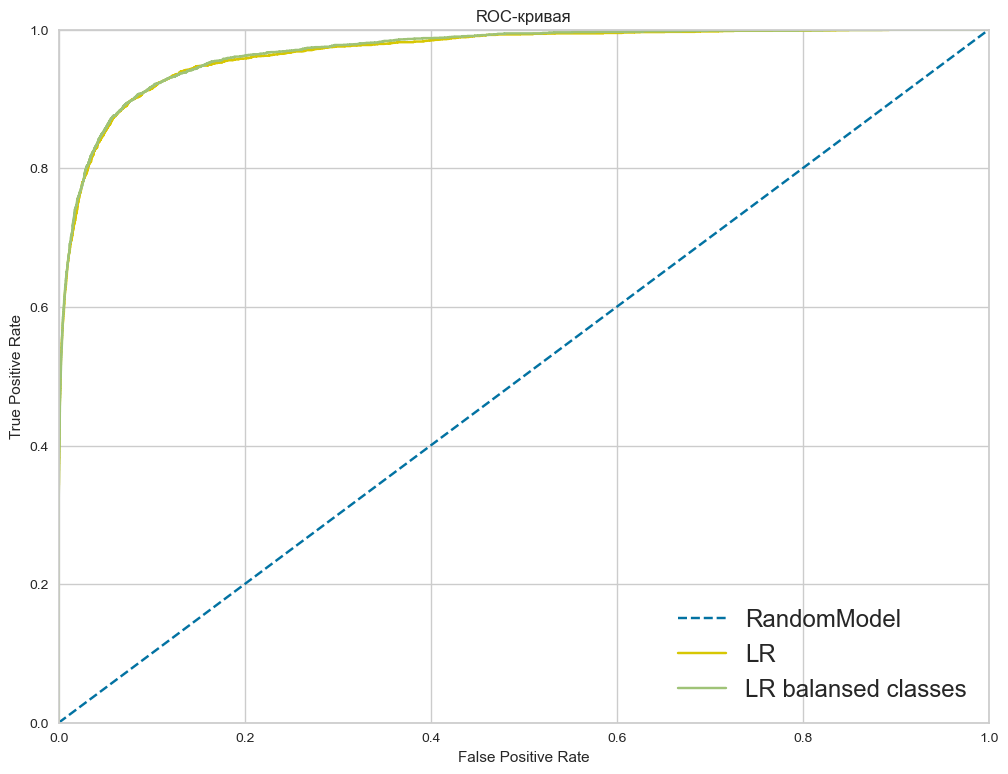

In [19]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(X_train, y_train)
probabilities_valid = classificator.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
valid_f1 = f1_score(y_valid, classificator.predict(X_valid))
plt.plot(fpr, tpr, label='LR',color='y')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(X_train, y_train)
probabilities_valid = classificator.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(y_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(y_valid, classificator.predict(X_valid))
plt.plot(fpr, tpr, label='LR balansed classes', color='g')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [20]:
index = ['LogisticRegression',
         'LR balansed classes']
data = {'F1 на тренировочных данных':[train_f1,train_f1_ballanced],
        'F1 на валидационны данных':[valid_f1,
                           valid_f1_balanced],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced]}

data_balans = pd.DataFrame(data=data, index=index)
data_balans

,F1 на тренировочных данных,F1 на валидационны данных,AUC-ROC
LogisticRegression,0.702389,0.721591,0.968469
LR balansed classes,0.753507,0.755698,0.969975


Количественная интерпретация ROC даёт показатель AUC (Area Under Curve) — площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор. Данные показывают, что балансировка улучшила качество классификатора. 

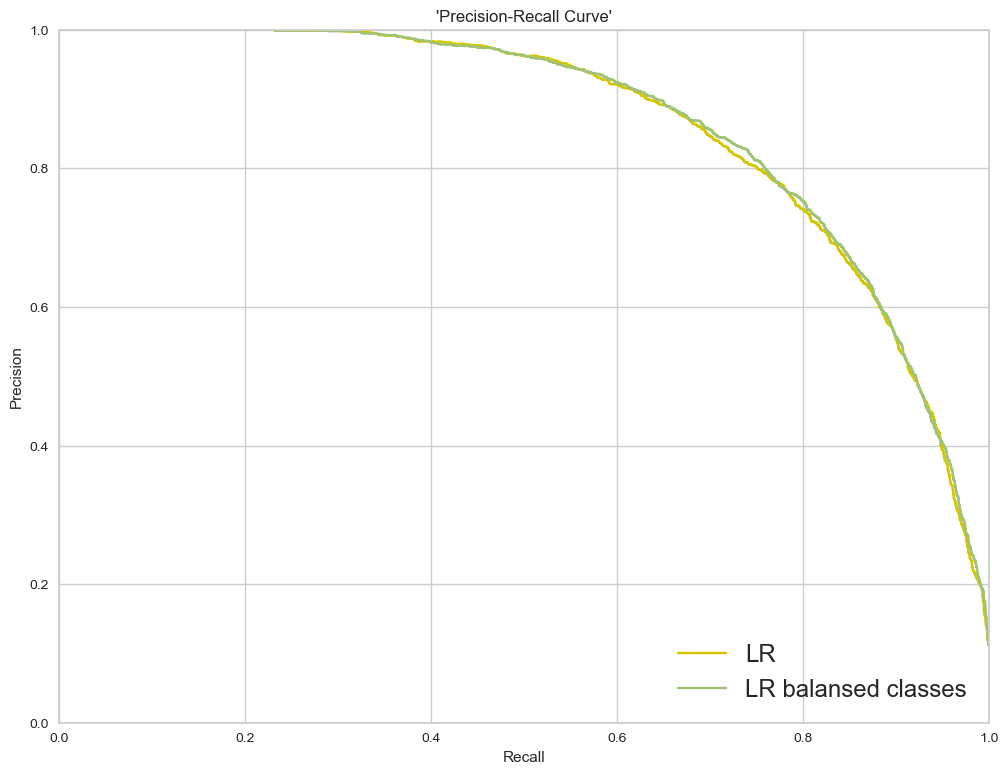

In [21]:
plt.figure(figsize=[12,9])

classificator = LogisticRegression()
classificator.fit(X_train, y_train)
probabilities_valid = classificator.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one_valid)
plt.plot(recall, precision, label='LR',color='y')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(X_train, y_train)
probabilities_valid = classificator.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one_valid)
plt.plot(recall, precision, label='LR balansed classes', color='g')


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("'Precision-Recall Curve'")
plt.show()

### Итоги исследования влияния дисбаланса на точность предсказаний:
Пришли к выводу, что балансировка позволяет улучшить значение метрики качества. Обучение моделей будем проводить с учетом устранения дисбаланса.

###  Модель LogisticRegression

In [22]:
pipe = Pipeline([
    (
    ('model', LogisticRegression(random_state=42))
    )
    ])


param_grid =[
        {

            'model__solver':['newton-cg', 'liblinear'],
            'model__C':[1, 10],
            'model__class_weight':[dict_classes]
        }
]
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=cv, verbose=True, n_jobs=-1)
best_grid = grid.fit(X_train, y_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)
cv_f1_LR = grid.best_score_
LR_best_params = grid.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters is: {'model__C': 10, 'model__class_weight': {0: 1, 1: 9}, 'model__solver': 'newton-cg'}
Best score is: 0.7642602363576867


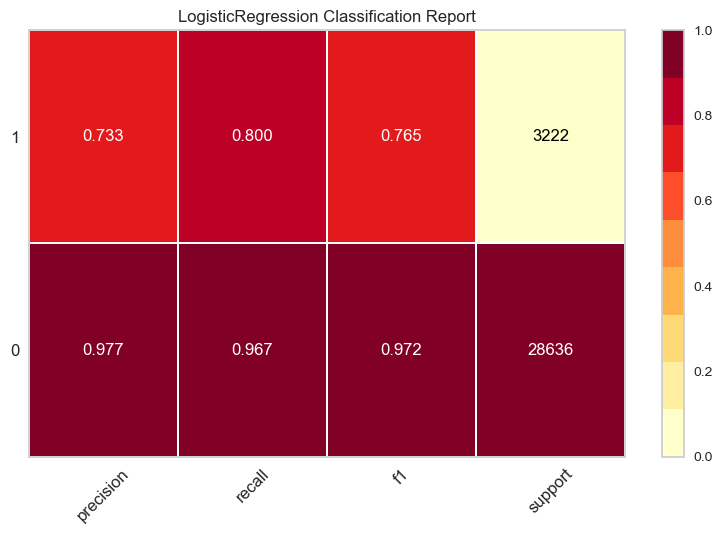

Значение F1 для сбалансированной модели LogisticRegression с подобранными гиперпараметрами:
F1 на тестовой выборке 0.7642602363576867
F1 на валидационной выборке 0.7648716807595313
CPU times: user 9.5 s, sys: 3.08 s, total: 12.6 s
Wall time: 3.16 s


In [23]:
%%time

classificator = LogisticRegression(C=10, random_state=42, solver='newton-cg',
                                   class_weight={0: 1, 1: 9})
classificator.fit(X_train, y_train)
target_predict = classificator.predict(X_valid)
valid_f1_LR = f1_score(y_valid, target_predict)


# Определение целевых классов
classes = ["0","1"]

# Создание модели классификации и визуализатора
model = classificator
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)       
visualizer.show() 



print('Значение F1 для сбалансированной модели LogisticRegression с подобранными гиперпараметрами:')
print('F1 на тестовой выборке', cv_f1_LR)
print('F1 на валидационной выборке', valid_f1_LR)

###  Модель DecisionTreeClassifier

In [24]:
pipe = Pipeline([
    (
    ('model', DecisionTreeClassifier(random_state=42))
    )
    ])


param_grid =[
        {

            'model__max_depth':[x for x in range(10,51,10)],
            'model__class_weight':[dict_classes]
        }
]
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=cv, verbose=True, n_jobs=-1)
best_grid = grid.fit(X_train, y_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)
cv_f1_DTC = grid.best_score_
DTC_best_params = grid.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters is: {'model__class_weight': {0: 1, 1: 9}, 'model__max_depth': 50}
Best score is: 0.6474853707574694


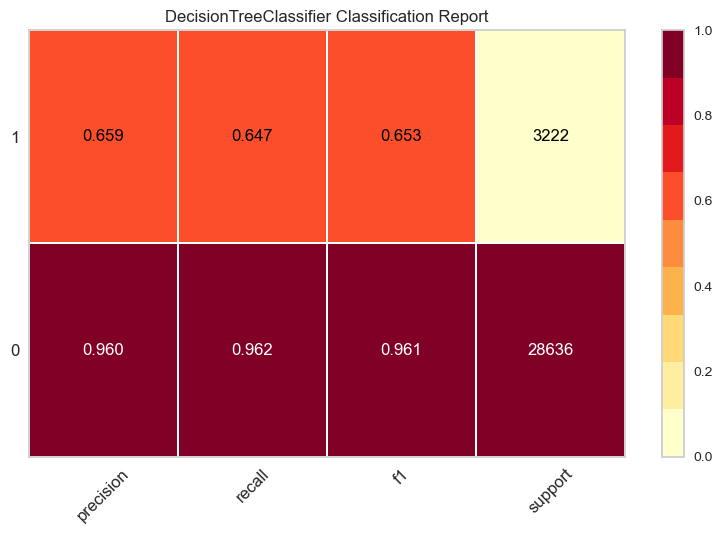

Значение F1 для модели DecisionTreeClassifier с подобранными гиперпараметрами:
F1 на тестовой выборке 0.6474853707574694
F1 на валидационной выборке 0.6531954887218046
CPU times: user 20.5 s, sys: 157 ms, total: 20.7 s
Wall time: 20.8 s


In [25]:
%%time

classificator = DecisionTreeClassifier(random_state=42, max_depth=50,
                                        class_weight={0: 1, 1: 9})
classificator.fit(X_train, y_train)
target_predict = classificator.predict(X_valid)
valid_f1_DTC = f1_score(y_valid, target_predict)

# Определение целевых классов
classes = ["0","1"]

# Создание модели классификации и визуализатора
model = classificator
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)       
visualizer.show() 



print('Значение F1 для модели DecisionTreeClassifier с подобранными гиперпараметрами:')
print('F1 на тестовой выборке', cv_f1_DTC)
print('F1 на валидационной выборке', valid_f1_DTC)

###  Модель CatBoostClassifier

In [26]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=200)
classificator.fit(X_train, y_train)
target_predict = classificator.predict(X_valid)
cv_f1_CBC = cross_val_score(classificator,
                            X_train,
                            y_train,
                            cv=cv,
                            scoring='f1').mean()
valid_f1_CBC = f1_score(y_valid, target_predict)

print('Значение F1 для модели CatBoostClassifier:')
print('F1 на тестовой выборке', cv_f1_CBC)
print('F1 на валидационной выборке', valid_f1_CBC)

Значение F1 для модели CatBoostClassifier:
F1 на тестовой выборке 0.7344841543057832
F1 на валидационной выборке 0.7466570292735816
CPU times: user 27min 12s, sys: 8min 27s, total: 35min 39s
Wall time: 7min 22s


###  Модель SGDClassifier

In [27]:
pipe = Pipeline([
    (
    ('model', SGDClassifier(random_state=42))
    )
    ])


param_grid =[
        {

            'model__loss':['hinge', 'log', 'modified_huber'],
            'model__learning_rate':['constant', 'optimal', 'adaptive'],
            'model__eta0':[0.1, 0.2, 0.3, 0.5],
            'model__class_weight':[dict_classes]
        }
]
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=cv, verbose=True, n_jobs=-1)
best_grid = grid.fit(X_train, y_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)
cv_f1_SGDC = grid.best_score_
DTC_best_params = grid.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters is: {'model__class_weight': {0: 1, 1: 9}, 'model__eta0': 0.3, 'model__learning_rate': 'adaptive', 'model__loss': 'modified_huber'}
Best score is: 0.7614404804741504


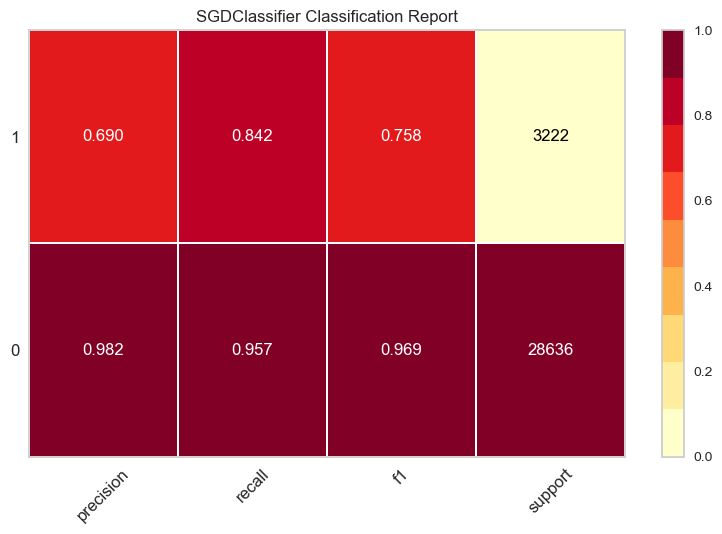

Значение F1 для модели SGDClassifier с подобранными гиперпараметрами:
F1 на тестовой выборке 0.7614404804741504
F1 на валидационной выборке 0.7582448295136949
CPU times: user 1.96 s, sys: 551 ms, total: 2.51 s
Wall time: 961 ms


In [28]:
%%time

classificator = SGDClassifier(random_state=42, eta0=0.3, learning_rate='adaptive',loss='modified_huber',
                              class_weight={0: 1, 1: 9})
classificator.fit(X_train, y_train)
target_predict = classificator.predict(X_valid)
valid_f1_SGDC = f1_score(y_valid, target_predict)

# Определение целевых классов
classes = ["0","1"]

# Создание модели классификации и визуализатора
model = classificator
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)       
visualizer.show() 

print('Значение F1 для модели SGDClassifier с подобранными гиперпараметрами:')
print('F1 на тестовой выборке', cv_f1_SGDC)
print('F1 на валидационной выборке', valid_f1_SGDC)

### Итоги обучения моделей

In [29]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[round(cv_f1_LR, 3),
                    round(cv_f1_DTC, 3),
                    round(cv_f1_CBC, 3),
                    round(cv_f1_SGDC, 3)],
        'F1 на валидации':[round(valid_f1_LR, 3),
                        round(valid_f1_DTC, 3),
                        round(valid_f1_CBC, 3),
                        round(valid_f1_SGDC, 3)]}

data_model = pd.DataFrame(data=data, index=index)
data_model

,F1 на CV,F1 на валидации
LogisticRegression,0.764,0.765
DecisionTreeClassifier,0.647,0.653
CatBoostClassifier,0.734,0.747
SGDClassifier,0.761,0.758


Как видим из результирующей таблицы, лучший результат показала модель LogisticRegression. Видим, что модель SGDClassifier показала достаточно хороший результат. Для оценки модели на тестовых данных мы будем исследовать наилучшую модель - LogisticRegression.

## Анализ модели

Обучем лучшую модель на тестовых данных.

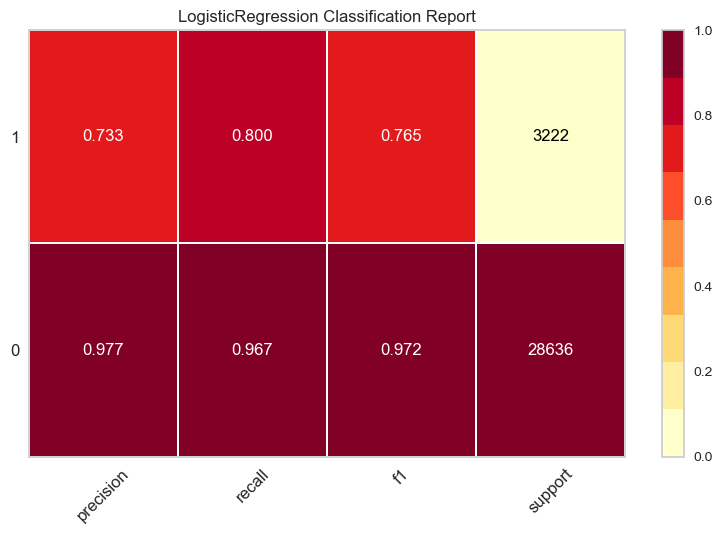

Метрики лучшей модели  - LogisticRegression
ROC AUC: 0.9665575875441943
F1: 0.7706339712918662



In [30]:

classificator = LogisticRegression(C=10, random_state=42, solver='newton-cg',
                                   class_weight={0: 1, 1: 9})
classificator.fit(X_train, y_train)
probabilities_test = classificator.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
predict_test = classificator.predict(X_test)

# Определение целевых классов
classes = ["0","1"]

# Создание модели классификации и визуализатора
model = classificator
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)       
visualizer.show() 


print('Метрики лучшей модели  - LogisticRegression')
print('ROC AUC:', roc_auc_score(y_test, probabilities_one_test))
print('F1:', f1_score(y_test, predict_test))
print()


### Итоги анализа модели
Полученный результат значения F1 удовлетворяет требованию технического задания. Данную модель можно использовать для классификации комментариев на позитивные и негативные, чтобы отправлять токсичные комментарии на модерацию. 

## Общий вывод

Нами были рассмотрены данные, которые содержит 159292 наблюдений - англоязычных комментариев. Был выявлен дисбаланс в распределении целевого признака который составил 1:8,8. Для исследования были использованы все наблюдения.

Данные были подготовлены для обучения и сформированы выборки: для обучения, валидационная и тестовая.


В результате исследования влияния дисбаланса на точность предсказаний пришли к выводу, что балансировка позволяет улучшить значение метрики качества.



In [31]:
data_balans

,F1 на тренировочных данных,F1 на валидационны данных,AUC-ROC
LogisticRegression,0.702389,0.721591,0.968469
LR balansed classes,0.753507,0.755698,0.969975


Балансировка была учтена при обучении моделей.


Нами были обучены следующие модели:
- LogisticRegression,
- DecisionTreeClassifier,
- CatBoostClassifier,
- SGDClassifier.


Как видим из результирующей таблицы, лучший результат показала модель LogisticRegression. Видим, что модель SGDClassifier показала достаточно хороший результат. Для оценки модели на тестовых данных мы исследовали наилучшую модель - LogisticRegression.

In [32]:
data_model

,F1 на CV,F1 на валидации
LogisticRegression,0.764,0.765
DecisionTreeClassifier,0.647,0.653
CatBoostClassifier,0.734,0.747
SGDClassifier,0.761,0.758


Полученный результат значения F1 = 0.765 удовлетворяет требованию технического задания. Данную модель можно использовать для классификации комментариев на позитивные и негативные, чтобы отправлять токсичные комментарии на модерацию. 